# How to performs cell based segmentation with the watershed algorithm

In this notebook we will show you how to performs **watershed segmentation** of a grayscale image representing a biological tissue at cell level, *i.e.* where the signal is delimitatin cells.
We will details each step and thus use functions from the `algorithms` module.

This guide is not intended for **nuclei detection**, although it could work with some minor adjustments, there are probably more robust ways of performing this task.

In [1]:
%matplotlib inline
import numpy as np
from timagetk.algorithms.connexe import connected_components
from timagetk.algorithms.exposure import global_contrast_stretch
from timagetk.algorithms.linearfilter import linearfilter
from timagetk.algorithms.regionalext import regional_extrema
from timagetk.algorithms.watershed import watershed
from timagetk.components.spatial_image import SpatialImage
from timagetk.io import imread

/home/aurele/Soft/timagetk/src/timagetk/components/labelled_image.py:32: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


The image should be a 2D or 3D single channel grayscale image of a cellular tissue. 

In [2]:
from timagetk.io.image import _image_from_url
tmp_path = _image_from_url('https://zenodo.org/record/7151866/files/p58-t0-imgFus.inr.gz',
                           hash_value='48f6f9924289037c55ea785273c2fe72', hash_method='md5')
image = imread(tmp_path)

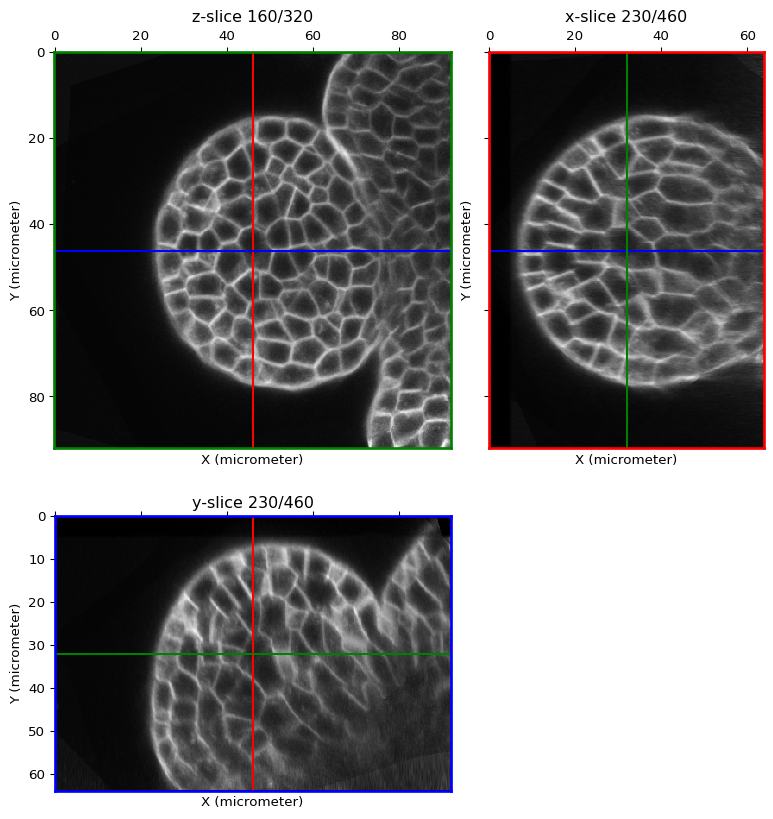

In [3]:
from timagetk.visu.stack import orthogonal_view
orthogonal_view(image)

## Pre-processing

### Optional - Intensity rescaling

It may be useful to start with **intensity rescaling** since the image contrast might not be homogeneous or the intensity range not optimal (*e.g.* ranging in `[15, 200]` on a signed 8bit image that have a `[0, 255]` range)

In [4]:
image = global_contrast_stretch(image)

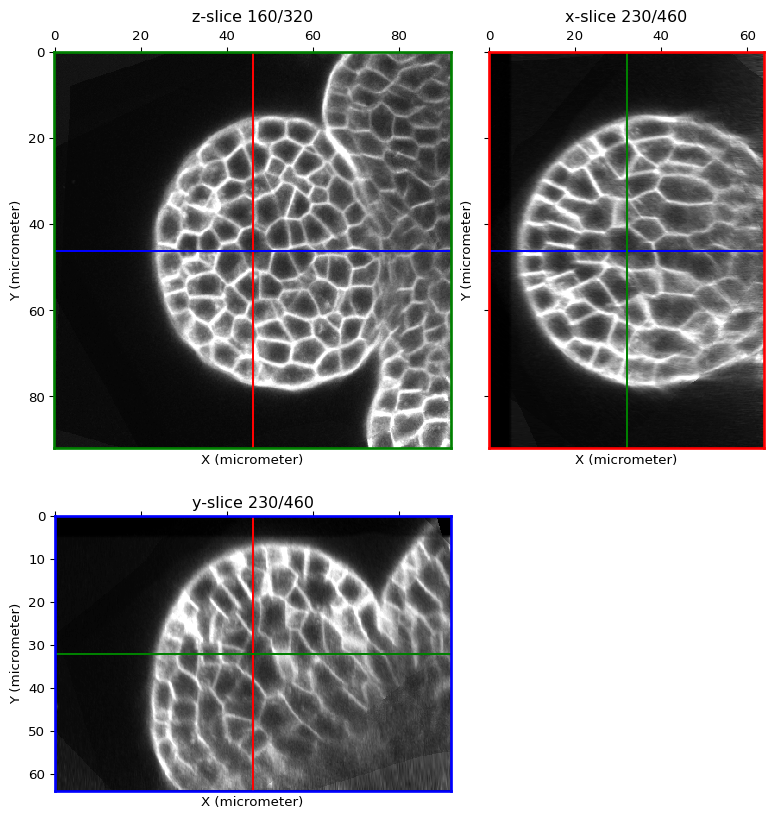

In [5]:
orthogonal_view(image)

### Linear filtering using Gaussian smoothing

To smooth out the noise in the image, we strongly advise to performs a *gaussian smoothing* prior to the following steps.

In [6]:
image = linearfilter(image, method="smoothing", sigma=1.0, real=True)
print(image.shape)

(320, 460, 460)


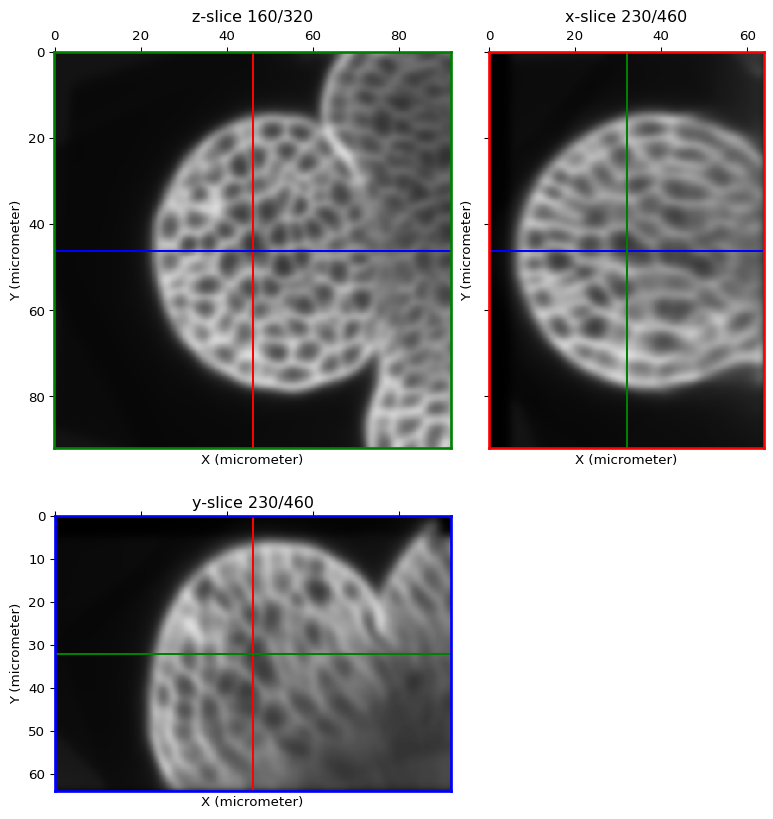

In [7]:
orthogonal_view(image)

## Processing

### Local minima detection

This is the most critical step with the choice of a good *h-minima* value.

In [8]:
from timagetk.array_util import guess_intensity_threshold
th = guess_intensity_threshold(image)
print(f"Automatic threshold value: {th}")

2022-10-06 11:37:54,082 - guess_intensity_threshold - 543 - INFO - Automatically estimated intensity threshold value: 62.400000000000006


Automatic threshold value: 62.400000000000006


In [9]:
hmin = int(round(th)/2)
print(f"H-minimum value for detection of local minima: {hmin}")
ext_img = regional_extrema(image, height=hmin, method='minima')

H-minimum value for detection of local minima: 31


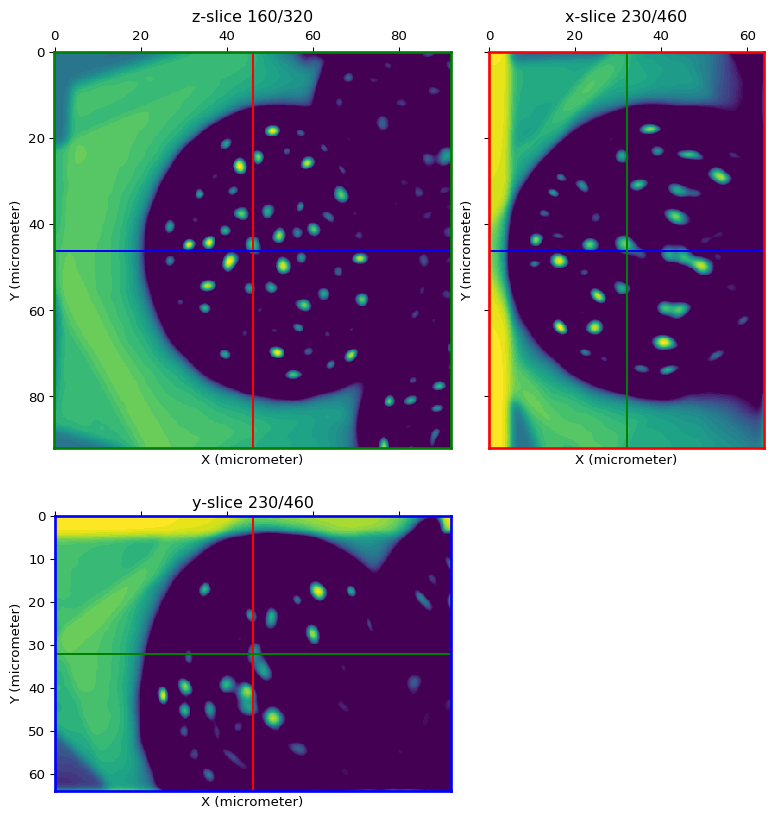

In [10]:
orthogonal_view(ext_img, cmap='viridis', val_range=[0, hmin])

### Connected component labelling of detected local minima

This step is labelling each detected local minima with a unique id to generate a *seed image*.

In [11]:
seeds_image = connected_components(ext_img, low_threshold=1, high_threshold=hmin)

In [12]:
n_seeds = len(np.unique(seeds_image)) - 1  # '0' is in the list!
print("Detected {} seeds!".format(n_seeds))

Detected 202 seeds!


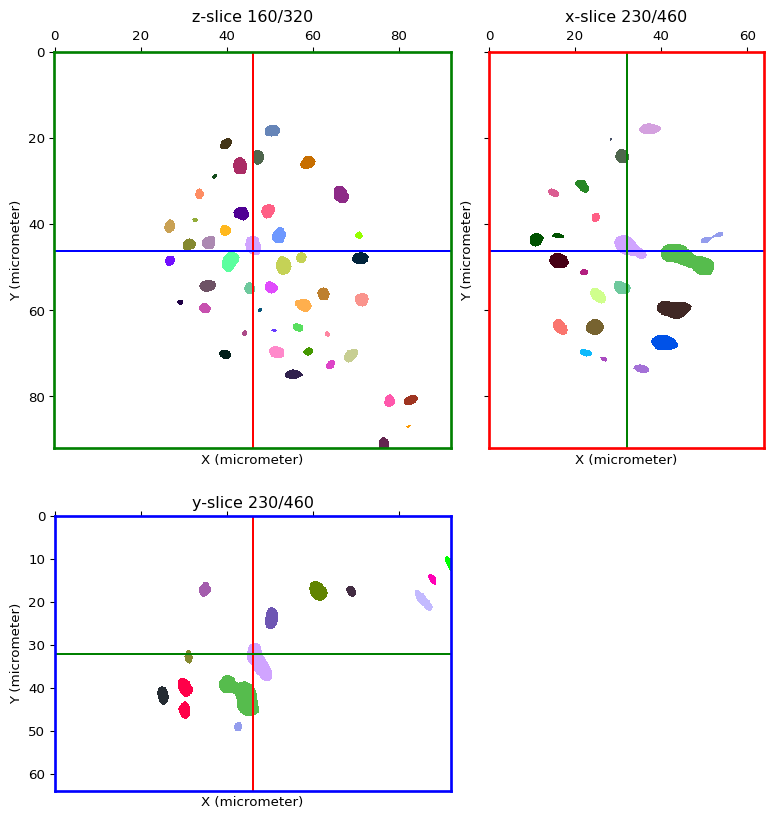

In [13]:
orthogonal_view(seeds_image, cmap='glasbey', val_range=[1, n_seeds])

### Seeded watershed

The previously detected seeds are now used by the watershed algorithm to "flood" the cells.

In [14]:
label_image = watershed(image, seeds_image, method="first")

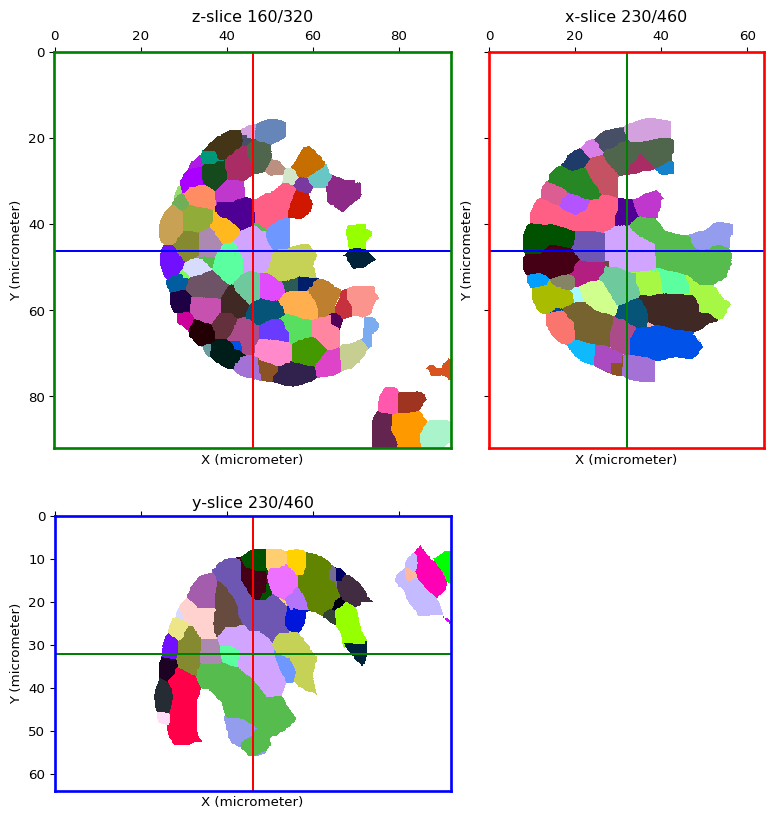

In [15]:
orthogonal_view(label_image, cmap='glasbey', val_range=[1, n_seeds])